# This is a notebook to process SH2 DMS experimental data


Data from Jason (Neel Shaw lab)

In [1]:
# data directory
data_dir= '/Users/yunyao_1/Dropbox/SH2'
# excel file 
data_dms = data_dir + '/media-3.xlsx'
# it contains several sheets, each sheet for different experiment set up
# read the excel file and parese the data
import pandas as pd
def read_excel_sheets(file_path):
    # Read all sheets from the Excel file
    xls = pd.ExcelFile(file_path)
    sheets = {sheet_name: pd.read_excel(xls, sheet_name) for sheet_name in xls.sheet_names}
    return sheets

# read the excel file
s = read_excel_sheets(data_dms)
# print the names of the sheets
print("Sheets in the Excel file:")
for sheet_name in s.keys():
    print(sheet_name)

Sheets in the Excel file:
SHP2-FL_vSrc-FL_column
SHP2-FL_cSrc-KD_column
SHP2-FL_vSrc-FL_matrix
SHP2-FL_cSrc-KD_matrix


In [2]:
# reaad SHP2-FL_vSrc-FL_column and SHP2-FL_cSrc-KD_column
shp2_fl_vsrc_fl_column = s['SHP2-FL_vSrc-FL_column']
shp2_fl_csrc_kd_column = s['SHP2-FL_cSrc-KD_column']

In [3]:
# print the first few rows of each sheet
print("\nSHP2-FL_vSrc-FL_column:")
print(shp2_fl_vsrc_fl_column.head())
print("\nSHP2-FL_cSrc-KD_column:")
print(shp2_fl_csrc_kd_column.head())


SHP2-FL_vSrc-FL_column:
   index  Tile WT  POS MUT Mutation  Enrichment (ave)  Enrichment (stdev)  \
0      1     1  M    1   K      M1K         -0.025105            0.040551   
1      2     1  M    1   R      M1R         -0.075476            0.056025   
2      3     1  M    1   H      M1H         -0.090064            0.056877   
3      4     1  M    1   D      M1D          0.141170            0.083077   
4      5     1  M    1   E      M1E         -0.030519            0.093436   

   # of reps  GOF (M+SD)  LOF (M-SD)  cancer-high-freq  cancer-all  \
0          3         0.0         0.0             False       False   
1          3         0.0         0.0             False       False   
2          3         0.0         0.0             False       False   
3          3         1.0         0.0             False       False   
4          3         0.0         0.0             False       False   

   pathogenic  uncertain database  Hamming dist to Human WT  
0       False      False     

In [4]:
# extract sequence inform form SHP2-FL_vSrc-FL_column
# the sequne in in WT, AND POS column for aa and aa pos, read every 21 rows
def extract_sequences(df):
    sequences = []
    positions = []
    for i in range(0, len(df), 21):
        if i + 20 < len(df):  # Ensure we don't go out of bounds
            seq = df.iloc[i:i+21]['WT'].tolist()
            pos = df.iloc[i:i+21]['POS'].tolist()
            sequences.append(seq)
            positions.append(pos)
    return sequences, positions

# extract sequences and positions from SHP2-FL_vSrc-FL_column
sequences_vsrc_fl, positions_vsrc_fl = extract_sequences(shp2_fl_vsrc_fl_column)
# extract sequences and positions from SHP2-FL_cSrc-KD_column
sequences_csrc_kd, positions_csrc_kd = extract_sequences(shp2_fl_csrc_kd_column)

In [5]:
# print the first few sequences and positions
import numpy as np
print("\nExtracted sequences from SHP2-FL_vSrc-FL_column:")
seq=np.array(sequences_vsrc_fl)
print(seq[:,0].shape)


Extracted sequences from SHP2-FL_vSrc-FL_column:
(593,)


In [6]:
import numpy as np

def array_to_fasta(array, header="sequence_1", line_width=80):
    """
    Converts a NumPy array into FASTA format.

    Args:
        array (np.ndarray): Input sequence array.
        header (str): Header/identifier for the FASTA file.
        line_width (int): Maximum line width for sequence lines.

    Returns:
        str: Sequence in FASTA format.
    """
    # Flatten the array to ensure it is 1D
    sequence = ''.join(array.flatten().astype(str))
    
    # Format the sequence into lines of the specified width
    formatted_sequence = '\n'.join(
        sequence[i:i + line_width] for i in range(0, len(sequence), line_width)
    )
    
    # Combine header and formatted sequence
    fasta_format = f">{header}\n{formatted_sequence}"
    return fasta_format



fasta = array_to_fasta(seq[:,0], header="SH2_WT_sequence")
print(fasta)

>SH2_WT_sequence
MTSRRWFHPNITGVEAENLLLTRGVDGSFLARPSKSNPGDFTLSVRRNGAVTHIKIQNTGDYYDLYGGEKFATLAELVQY
YMEHHGQLKEKNGDVIELKYPLNCADPTSERWFHGHLSGKEAEKLLTEKGKHGSFLVRESQSHPGDFVLSVRTGDDKGES
NDGKSKVTHVMIRCQELKYDVGGGERFDSLTDLVEHYKKNPMVETLGTVLQLKQPLNTTRINAAEIESRVRELSKLAETT
DKVKQGFWEEFETLQQQECKLLYSRKEGQRQENKNKNRYKNILPFDHTRVVLHDGDPNEPVSDYINANIIMPEFETKCNN
SKPKKSYIATQGCLQNTVNDFWRMVFQENSRVIVMTTKEVERGKSKCVKYWPDEYALKEYGVMRVRNVKESAAHDYTLRE
LKLSKVGQGNTERTVWQYHFRTWPDHGVPSDPGGVLDFLEEVHHKQESIMDAGPVVVHCSAGIGRTGTFIVIDILIDIIR
EKGVDCDIDVPKTIQMVRSQRSGMVQTEAQYRFIYMAVQHYIETLQRRIEEEQKSKRKGHEYTNIKYSLADQTSGDQSPL
PPCTPTPPCAEMREDSARVYENVGLMQQQKSFR


In [7]:
# plot the heatmap data
import seaborn as sns
import matplotlib.pyplot as plt  



def DMS_reader(excel_data):

    # Set the index to the first column (which contains the row names)
    excel_data.set_index(excel_data.columns[0], inplace=True)


    # Set the first row as the top-level column headers and the second row as the second level
    excel_data.columns = pd.MultiIndex.from_arrays(
        [excel_data.columns, excel_data.iloc[0]]
    )
    # drop out the top row
    excel_data = excel_data.iloc[1:]

    # Ensure numerical values for the heatmap (convert all cells to float)
    excel_data = excel_data.apply(pd.to_numeric, errors='coerce')

    return excel_data

heatmap_sheet_SHP2_FL_vSrc = s['SHP2-FL_vSrc-FL_matrix'].copy()

heatmap_SHP2_FL_vSrc=DMS_reader(heatmap_sheet_SHP2_FL_vSrc)
#heatmap_4DGP.columns
heatmap_SHP2_FL_vSrc
      

,1,2,3,4,5,6,7,8,9,10,...,584,585,586,587,588,589,590,591,592,593
,M,T,S,R,R,W,F,H,P,N,...,G,L,M,Q,Q,Q,K,S,F,R
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
K,-0.025105,-0.048198,-0.028991,0.059367,-0.088260,0.371825,0.328932,0.229601,0.160649,-0.065908,...,-0.108054,-0.037632,-0.055422,0.044434,-0.043897,0.017312,0.000000,0.053590,-0.007663,-0.018417
R,-0.075476,0.038811,-0.000510,0.000000,0.000000,0.373402,0.216272,0.231452,-0.039214,0.019142,...,0.217857,-0.052791,0.038471,-0.041588,0.033849,-0.018660,-0.029773,-0.016347,0.010203,0.000000
H,-0.090064,-0.032048,-0.012631,-0.015961,0.052171,0.320982,0.265693,0.000000,0.001173,0.072048,...,0.010761,0.025087,-0.052466,0.042417,0.026523,-0.045376,0.119739,0.112294,-0.012688,-0.044347
D,0.141170,-0.141194,-0.039683,-0.033854,-0.040095,0.231106,0.180609,0.107131,0.298481,-0.055820,...,-0.021623,0.078680,-0.100014,-0.047035,0.005838,-0.008316,-0.047266,-0.090271,-0.039978,-0.086552
E,-0.030519,-0.014033,-0.062354,0.165660,-0.069857,0.291823,0.289291,0.160282,0.091564,0.129656,...,-0.057635,-0.050829,0.134229,-0.014037,0.226399,-0.105066,-0.058991,-0.047605,-0.023496,-0.077991
N,-0.089708,0.003920,0.045480,-0.049595,-0.106270,0.317220,0.272810,0.114894,0.159404,0.000000,...,-0.060939,0.167737,0.360722,0.321932,-0.024968,-0.051118,0.278816,NaN,0.013030,0.016220
Q,-0.052181,-0.012128,-0.008230,0.049705,-0.074779,0.370001,0.263572,0.144623,-0.054260,-0.032595,...,0.034077,-0.070817,-0.066632,0.000000,0.000000,0.000000,0.085258,0.066511,-0.049385,-0.030069
C,-0.108418,0.104401,-0.061950,-0.119767,-0.068334,0.333290,0.180280,0.024475,0.161081,0.108561,...,-0.044528,-0.040697,0.097283,0.018920,-0.010288,-0.085435,-0.003598,-0.019014,0.110671,-0.025929


Figure saved to /Users/yunyao_1/Dropbox/SH2/SHP2_FL_vSrc_heatmap.png


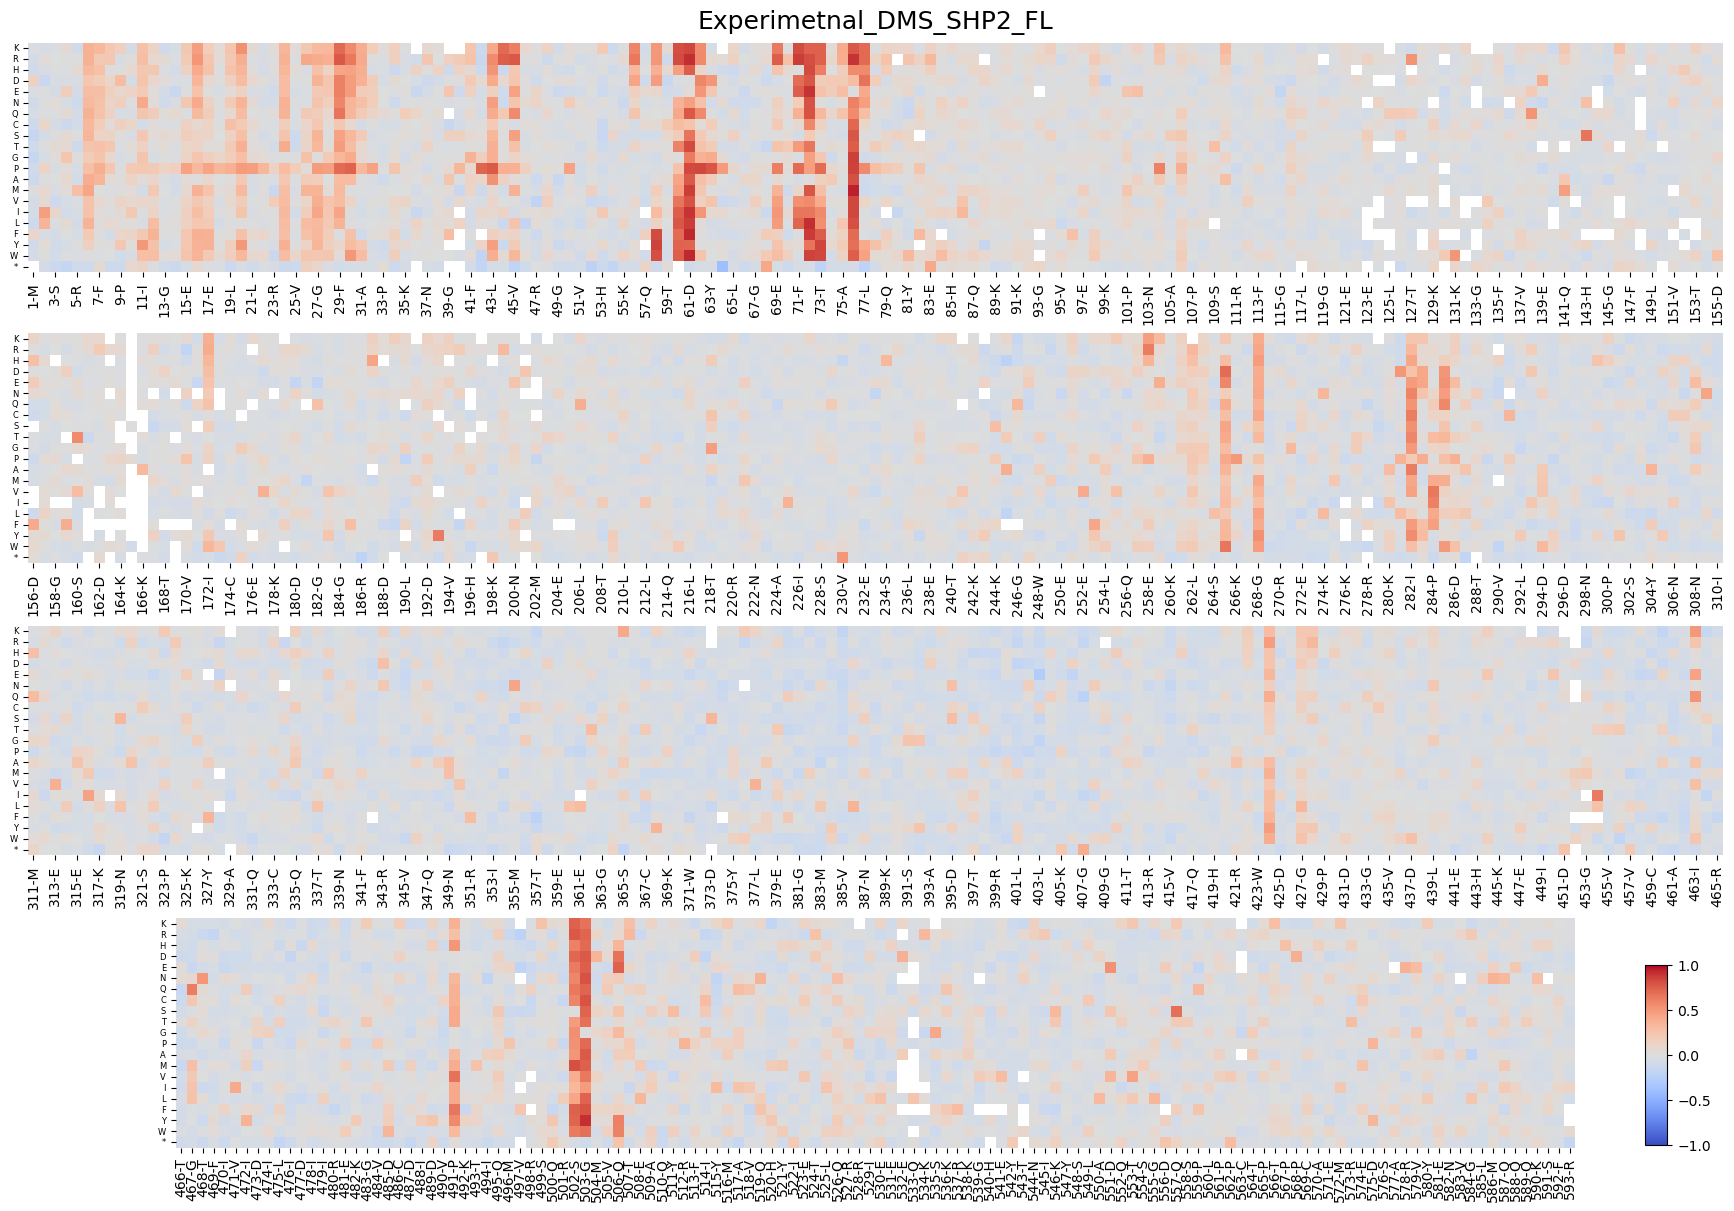

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def plot_heatmap(heatmap_data,vmin, vmax,title, save=False, path=None):
    # Assuming heatmap_data is your DataFrame
    num_columns_per_plot = 155
    num_plots = (heatmap_data.shape[1] + num_columns_per_plot - 1) // num_columns_per_plot

    # Determine the color range
    vmin = vmin  # Minimum value in the entire dataset
    vmax = vmax  # Maximum value in the entire dataset

    # Create subplots
    fig, axes = plt.subplots(
        nrows=num_plots, ncols=1, 
        figsize=(22, num_plots * 3),  # Adjusted height to fit all plots
        constrained_layout=True
    )

    # Plot each subset of data
    for i, ax in enumerate(axes):
        start_col = i * num_columns_per_plot
        end_col = min((i + 1) * num_columns_per_plot, heatmap_data.shape[1])
        data_subset = heatmap_data.iloc[:, start_col:end_col]
        
        sns.heatmap(
            data_subset, 
            annot=False, 
            cmap='coolwarm', 
            cbar=False,  # Disable individual color bars
            vmin=vmin, 
            vmax=vmax, 
            square=True,  # Ensure square pixels
            ax=ax
        )
        #ax.set_title(f"Columns {start_col + 1} to {end_col}", fontsize=14)
        # Adjust x-axis tick labels (every other one)
        #ax.set_xticks(range(0, data_subset.shape[1], 2))  # Every other x-tick
        #ax.set_xticklabels(data_subset.columns[::2], rotation=45, ha="right")  # Rotate for readability
        
        # Ensure all y-axis tick labels are shown
        ax.set_yticks(np.arange(data_subset.shape[0]) + 0.5)
        ax.set_yticklabels(data_subset.index, rotation=0,fontsize=6)  # No rotation for y-axis ticks
        ax.set_xlabel('')  # Remove x-axis title
        ax.set_ylabel('')  # Remove y-axis title

    # Add a single shared color bar
    cbar_ax = fig.add_axes([0.85, 0.05, 0.01, 0.15])  # Position of the color bar
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax)

    # Set an overall title for the figure
    plt.suptitle(f'{title}', fontsize=18)
  
 
    # Save the figure if required
    if save and path:
        plt.savefig(path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {path}")

    plt.show()


plot_heatmap(heatmap_SHP2_FL_vSrc,-1, 1,title='Experimetnal_DMS_SHP2_FL',  save=True, path=data_dir + '/SHP2_FL_vSrc_heatmap.png')





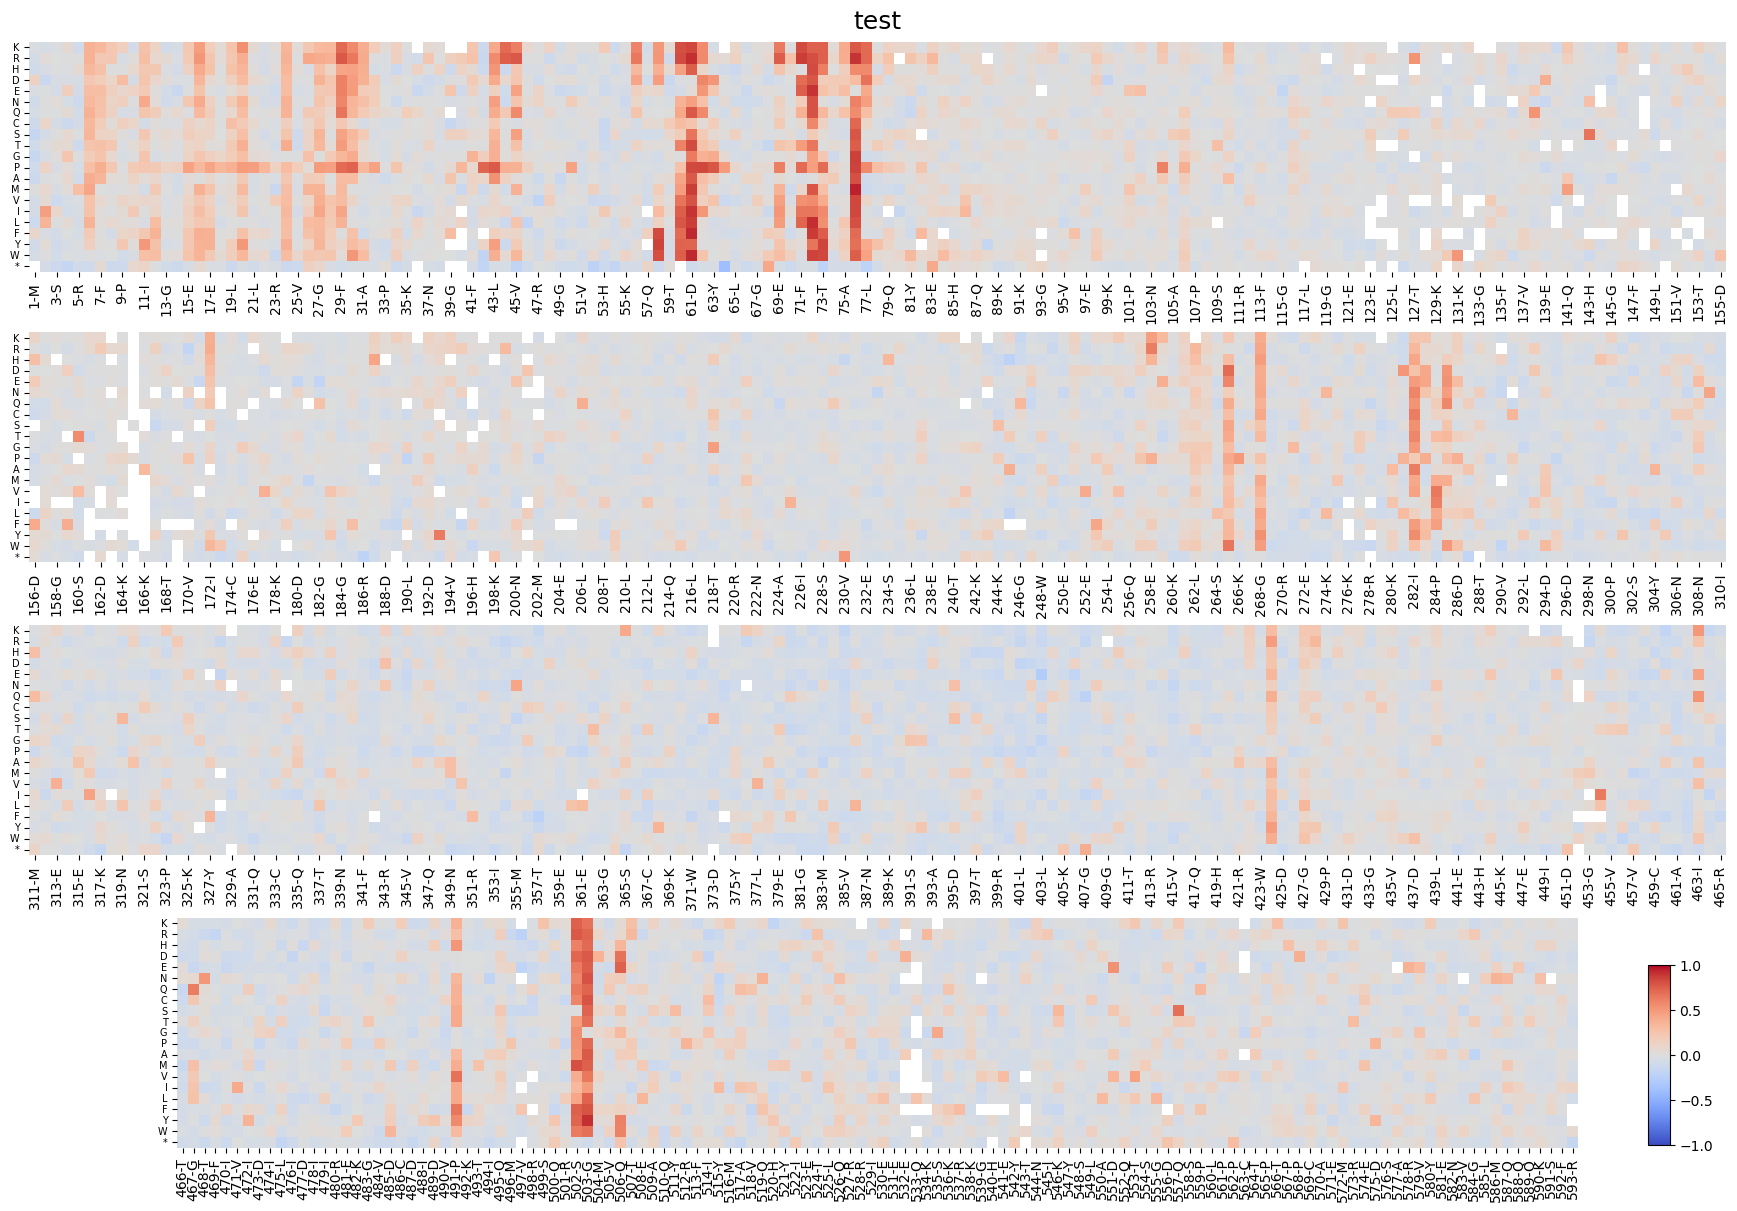

In [9]:
# used for both computational and experimetnal data
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def plot_heatmap(heatmap_data, vmin, vmax, title, save=False, path=None, x_label_size=7, y_label_size=7):
    """
    Plots a heatmap in multiple subplots with a shared color bar.

    Parameters:
    - heatmap_data: pd.DataFrame
        The data to plot.
    - vmin, vmax: float
        Minimum and maximum values for the heatmap color scale.
    - title: str
        Title of the overall figure.
    - save: bool
        Whether to save the plot to a file.
    - path: str
        Path to save the plot if save=True.
    - x_label_size: int
        Font size for x-axis tick labels.
    - y_label_size: int
        Font size for y-axis tick labels.
    """
    num_columns_per_plot = 155
    num_plots = (heatmap_data.shape[1] + num_columns_per_plot - 1) // num_columns_per_plot
    #heatmap_data.columns = [f"{col[0]}{col[1]}" for col in heatmap_data.columns]

    # Create subplots
    fig, axes = plt.subplots(
        nrows=num_plots, ncols=1, 
        figsize=(22, num_plots * 3),  # Adjust height based on plots
        constrained_layout=True
    )

    if num_plots == 1:  # Ensure axes is iterable even for a single plot
        axes = [axes]

    # Plot each subset of data
    for i, ax in enumerate(axes):
        start_col = i * num_columns_per_plot
        end_col = min((i + 1) * num_columns_per_plot, heatmap_data.shape[1])
        data_subset = heatmap_data.iloc[:, start_col:end_col]
        
        sns.heatmap(
            data_subset,
            annot=False,
            cmap='coolwarm',
            cbar=False,
            vmin=vmin,
            vmax=vmax,
            square=True,
            ax=ax
        )

        # # Adjust x-axis ticks
        # ax.set_xticks(np.arange(data_subset.shape[1]) + 0.5)
        # if data_subset.shape[1] > 1:
        #     xtick_labels = [
        #         label if idx % 2 == 0 else "" 
        #         for idx, label in enumerate(data_subset.columns)
        #     ]
        #     ax.set_xticklabels(xtick_labels, rotation=45, ha="center", fontsize=x_label_size)

        # Adjust y-axis ticks
        ax.set_yticks(np.arange(data_subset.shape[0]) + 0.5)
        ax.set_yticklabels(data_subset.index, rotation=0, fontsize=y_label_size)

        # Remove axis labels
        ax.set_xlabel("")
        ax.set_ylabel("")

    # Add a shared color bar
    cbar_ax = fig.add_axes([0.85, 0.05, 0.01, 0.15]) # Adjust dynamically based on figure
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax)

    # Set an overall title
    plt.suptitle(title, fontsize=18)

    # Save the figure if required
    if save and path:
        plt.savefig(path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {path}")
    
    plt.show()

plot_heatmap(heatmap_SHP2_FL_vSrc, -1, 1, 'test')

In [10]:
# read in the computational data
comp_dms='/Users/yunyao_1/Documents/GitHub/structural_evo_breakdown/SH2/output'
inbibited_4DGP = comp_dms + '/4DGP_mutated_seqs_scores.csv'
Computed_4DGP = pd.read_csv(inbibited_4DGP)
Computed_4DGP.head(20)

,seqid,log_likelihood,log_likelihood_target
0,wt,-1.239861,-1.239861
1,S1A,-1.239981,-1.239981
2,S1C,-1.244437,-1.244437
3,S1D,-1.238238,-1.238238
4,S1E,-1.240809,-1.240809
5,S1F,-1.247318,-1.247318
6,S1G,-1.239003,-1.239003
7,S1H,-1.243834,-1.243834
8,S1I,-1.247565,-1.247565
9,S1K,-1.236191,-1.236191


In [11]:
AAs = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

In [12]:
# Sequence information
seq_4DPG='''SRRWFHPNITGVEAENLLLTRGVDGSFLARPSKSNPGDFTLSVRRNGAVTHIKIQNTGDYYDLYGGEKFATLAELVQYYMEHHGQLKEKNGDVIELKYPLNCADPTSERWFHGHLSGKEAEKLLTEKGKHGSFLVRESQSHPGDFVLSVRTGDDKGESNDGKSKVTHVMIRCQELKYDVGGGERFDSLTDLVEHYKKNPMVETLGTVLQLKQPLNTTRINAAEIESRVRELSKGFWEEFETLQQQECKLLYSRKEGQRQENKNKNRYKNILPFDHTRVVLHDSDYINANIIMPEKKSYIATQGCLQNTVNDFWRMVFQENSRVIVMTTKEVERGKSKCVKYWPDEYALKEYGVMRVRNVKESAAHDYTLRELKLSKVGQGNTERTVWQYHFRTWPDHGVPSDPGGVLDFLEEVHHKQESIMDAGPVVVHCSAGIGRTGTFIVIDILIDIIREKGVDCDIDVPKTIQMVRSQRSGMVQTEAQYRFIYMAVQHYIETLQRR
'''
seq_4DPG=''.join(seq_4DPG.split())
seq_6CRF='''
GMTSRRWFHPNITGVEAENLLLTRGVDGSFLARPSKSNPGDFTLSVRRNGAVTHIKIQNTGDYYDLYGGEKFATLAKLVQYYMEHHGQLKGDVIELKYPLNCADPTSERWFHGHLSGKEAEKLLTEKGKHGSFLVREDFVLSVRTKVTHVMIRCKYDVGGGERFDSLTDLVEHYKKNPMLQLKQPLNTTRINAAEIESRVRELSKLQGFWEEFETLQQQECKLLYSRKEGQRQENKNKNRYKNILPFDHTRVVLHDGDPNEPVSDYINANIIMPKSYIATQGCLQNTVNDFWRMVFQENSRVIVMTTKEVERGKSKCVKYWPDEYALKEYGVMRVRNVKESAAHDYTLRELKLSKVGQGNTERTVWQYHFRTWPDHGVPSDPGGVLDFLEEVHHKQESIMDAGPVVVHCSAGIGRTGTFIVIDILIDIIREKGVDCDIDVPKTIQMVRSQRSGMVQTEAQYRFIYMAVQHYIETL
'''
seq_6CRF=''.join(seq_6CRF.split())

seq_fl ='''MTSRRWFHPNITGVEAENLLLTRGVDGSFLARPSKSNPGDFTLSVRRNGAVTHIKIQNTGDYYDLYGGEKFATLAELVQY
YMEHHGQLKEKNGDVIELKYPLNCADPTSERWFHGHLSGKEAEKLLTEKGKHGSFLVRESQSHPGDFVLSVRTGDDKGES
NDGKSKVTHVMIRCQELKYDVGGGERFDSLTDLVEHYKKNPMVETLGTVLQLKQPLNTTRINAAEIESRVRELSKLAETT
DKVKQGFWEEFETLQQQECKLLYSRKEGQRQENKNKNRYKNILPFDHTRVVLHDGDPNEPVSDYINANIIMPEFETKCNN
SKPKKSYIATQGCLQNTVNDFWRMVFQENSRVIVMTTKEVERGKSKCVKYWPDEYALKEYGVMRVRNVKESAAHDYTLRE
LKLSKVGQGNTERTVWQYHFRTWPDHGVPSDPGGVLDFLEEVHHKQESIMDAGPVVVHCSAGIGRTGTFIVIDILIDIIR
EKGVDCDIDVPKTIQMVRSQRSGMVQTEAQYRFIYMAVQHYIETLQRRIEEEQKSKRKGHEYTNIKYSLADQTSGDQSPL
PPCTPTPPCAEMREDSARVYENVGLMQQQKSFR
'''
seq_fl=''.join(seq_fl.split())
# CTD=slice(275,414)
# Q_N_rich=slice(341,368)
# print(seq[CTD])
print(len(seq_4DPG),len(seq_6CRF),len(seq_fl))


499 475 593


In [13]:
# used for computation data
import pandas as pd
import numpy as np


def score_matrix_converter(input_dataframe:pd.DataFrame,inp_seq:str):
    df = input_dataframe

    # Parse mutation information
    wt_sequence = "wt"  # Define the wild-type sequence (inferred from seqid 'wt')
    mutations = df.loc[df['seqid'] != 'wt', 'seqid']

    # Determine the number of positions and possible mutations
    positions = set(int(m[1:-1]) for m in mutations)
    unique_residues = set(m[-1] for m in mutations)
    #print(unique_residues)

    # Create an empty matrix
    matrix = pd.DataFrame(
        data=np.nan,
        index=sorted(positions),  # Positions (rows)
        columns=sorted(unique_residues)  # Residues (columns)
    )

    # Fill in the wild-type values
    for position in matrix.index:
        matrix.at[position, wt_sequence] = df.loc[df['seqid'] == 'wt', 'log_likelihood'].values[0]

    # Fill in the mutations
    for _, row in df.iterrows():
        if row['seqid'] == 'wt':
            continue
        wt_residue, pos, mut_residue = row['seqid'][0], int(row['seqid'][1:-1]), row['seqid'][-1]
        matrix.at[pos, mut_residue] = row['log_likelihood']




    # # Fill NA values in each row with the WT value if there is only one NA in the row
    for index, row in matrix.iterrows():
        na_count = row.isna().sum()
        if na_count == 1:  # Check for exactly one NA value
            wt_value = row[wt_sequence]  # Get the WT value for this position
            matrix.loc[index] = row.fillna(wt_value)  # Fill the NA with WT value

    # # Change the index name to position + sequence
    # # Assuming seq_4DPG is a string representing the sequence

    if len(inp_seq) < len(positions):
        raise ValueError("Sequence length must match the number of positions.")

    index_name = [f"{position}{aa}" for position, aa in zip(sorted(positions), inp_seq)]
    matrix.index = index_name  # Set the modified index names
    score_matrix = matrix.transpose()

    # Display the resulting matrix
    return score_matrix


fitness_4DPG=score_matrix_converter(Computed_4DGP,seq_4DPG)




In [14]:


# calculate the difference score reference to wt data and drop the wt row
#ref_fitnes
def relative_fitness_converter(fitness_df:pd.DataFrame):
    ref_fitness=pd.DataFrame()
    for index, row in fitness_df.iterrows():
        #print(index)
        if index != 'wt':
            ref_fitness[index]=row-fitness_df.loc['wt']
        #ref_fitness_4DPG
    #fitness_4DPG.loc['wt']

    ref_fitness_t=ref_fitness.transpose()
    # rerank the index to match experimental data
    custom_order=['K', 'R', 'H', 'D', 'E', 'N', 'Q', 'C', 'S', 'T', 'G', 'P', 'A', 'M',
       'V', 'I', 'L', 'F', 'Y', 'W']

    # Convert the index to a categorical type with the custom order
    ref_fitness_t.index = pd.Categorical(ref_fitness_t.index, categories=custom_order, ordered=True)

    # Sort the DataFrame by the index
    sorted_ref_fitness_t =ref_fitness_t.sort_index()
    return sorted_ref_fitness_t

ref_fitness_4DPG_t=relative_fitness_converter(fitness_4DPG)

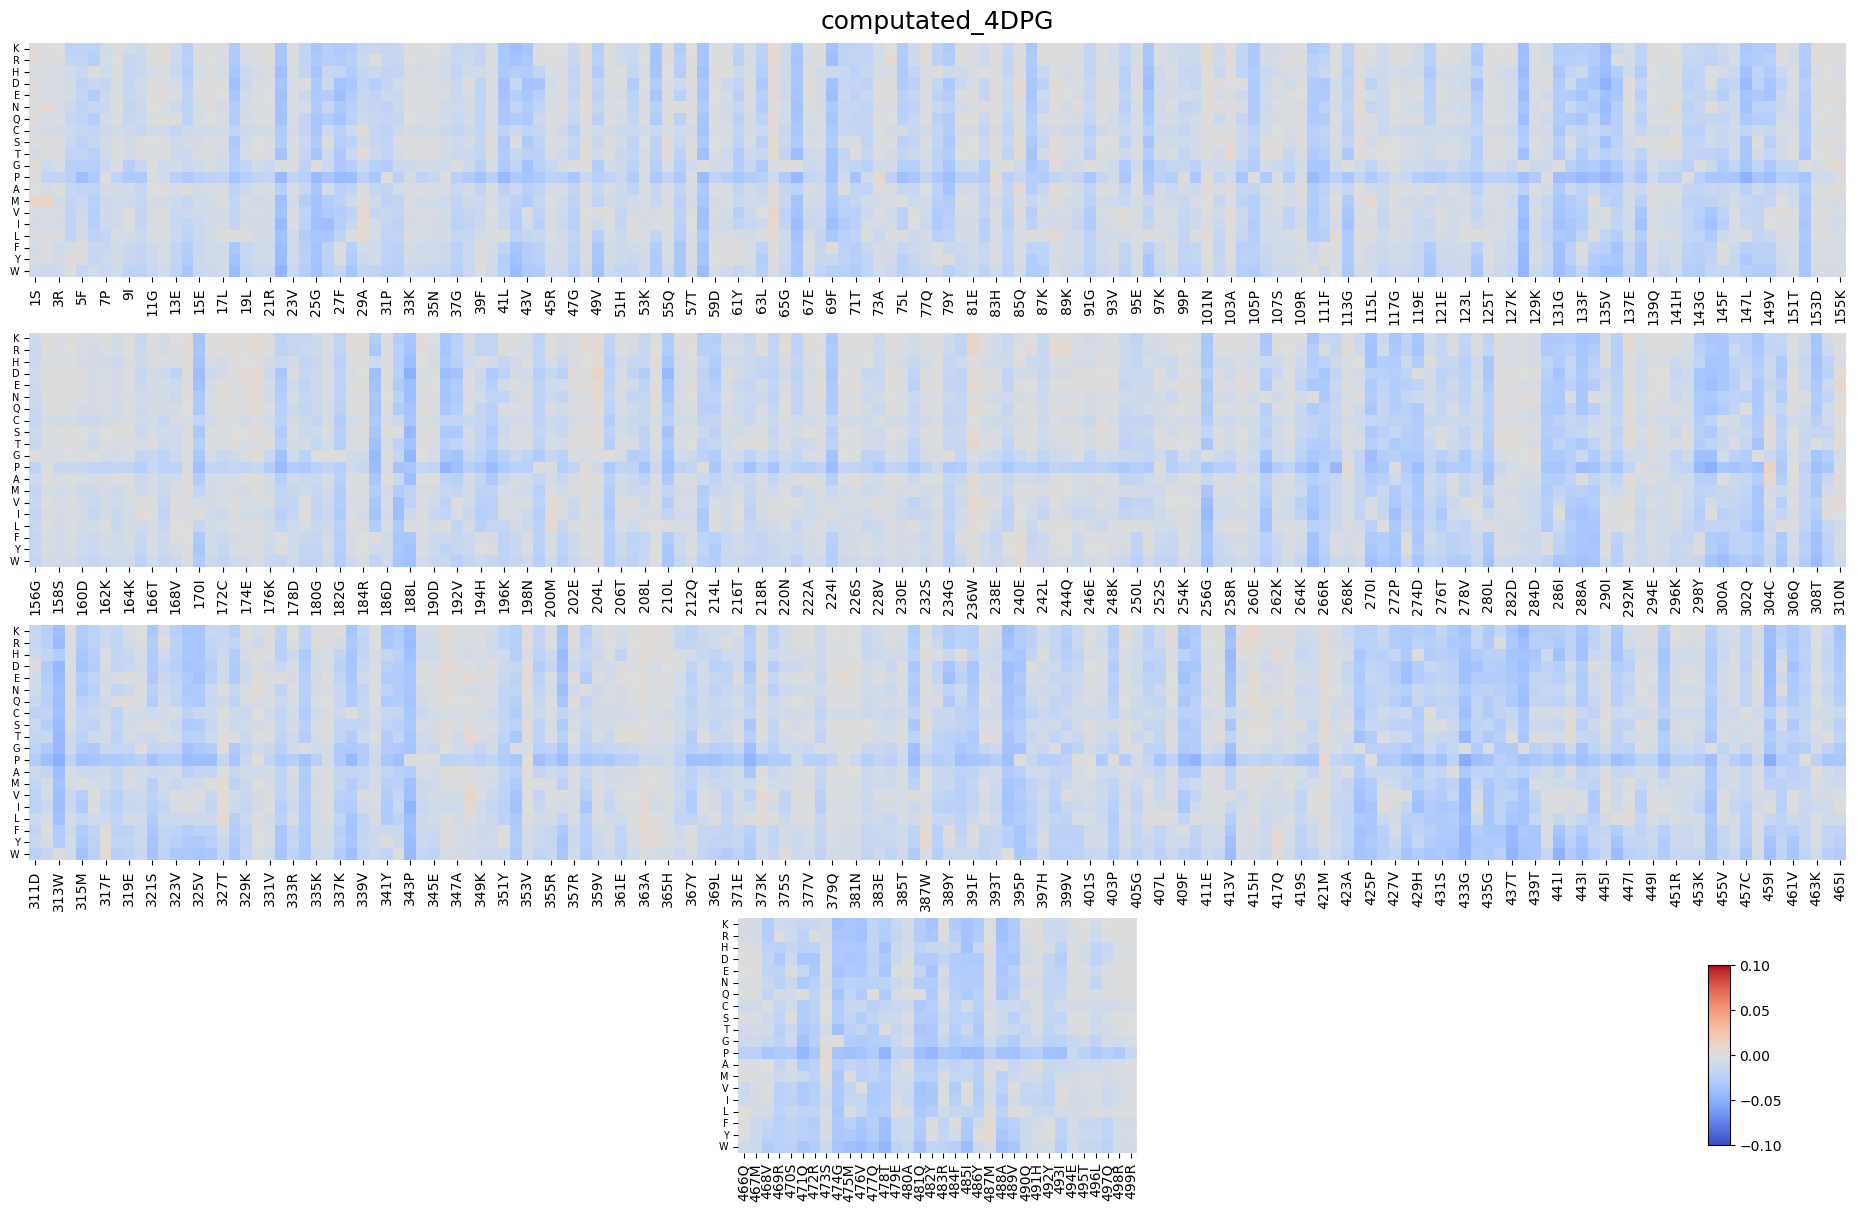

In [15]:
#plot the heatmap of fitness_4DPG
plot_heatmap(ref_fitness_4DPG_t,-0.1,0.1,title='computated_4DPG')




In [16]:
# process 6CRF data

comp_dms='/Users/yunyao_1/Documents/GitHub/structural_evo_breakdown/SH2/output'
active_6CRF= comp_dms + '/6CRF_mutated_seqs_scores.csv'
Computed_6CRF = pd.read_csv(active_6CRF)
fitness_6CRF=score_matrix_converter(Computed_6CRF,seq_6CRF)
ref_fitness_6CRF_t=relative_fitness_converter(fitness_6CRF)

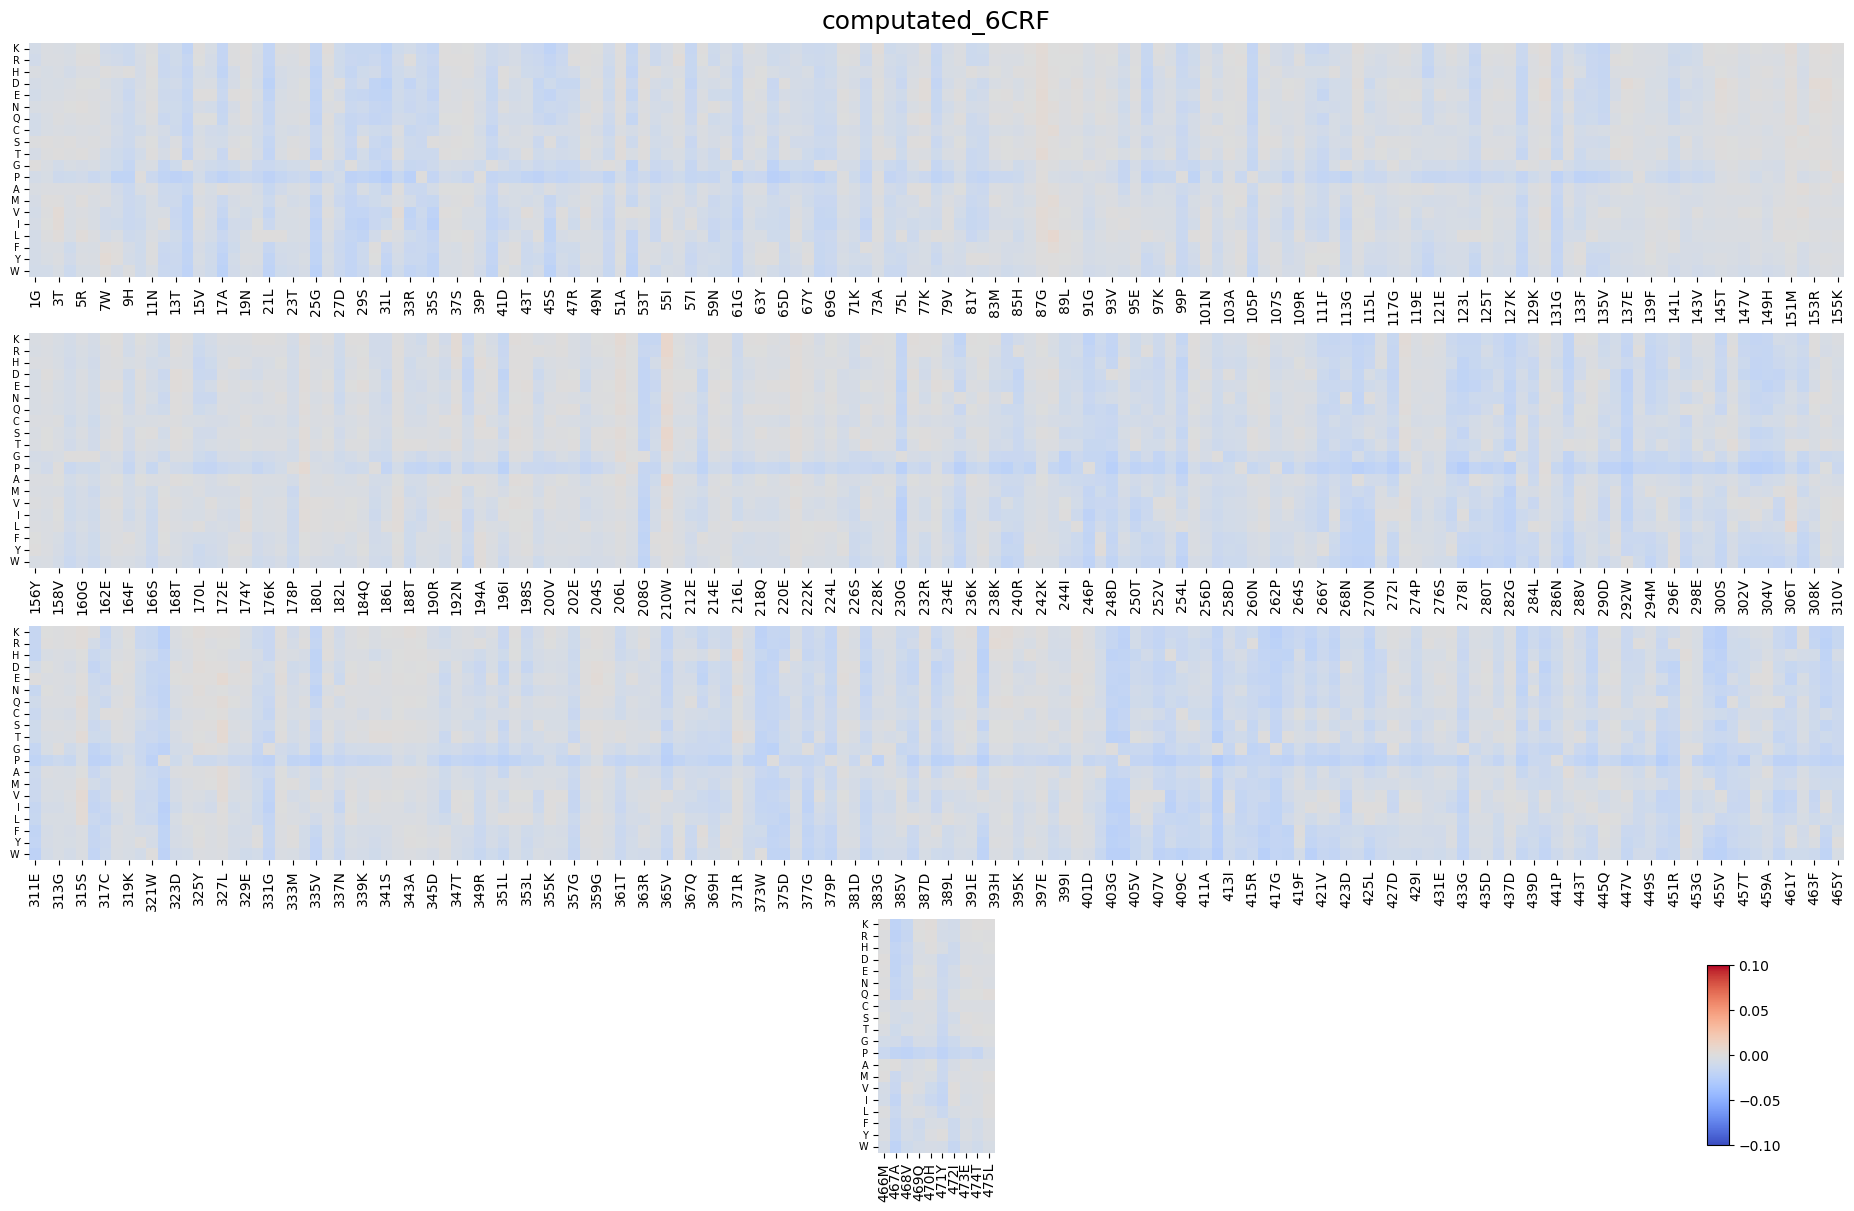

In [17]:
#PLOT 6CRF data
plot_heatmap(ref_fitness_6CRF_t,-0.1,0.1,title='computated_6CRF')

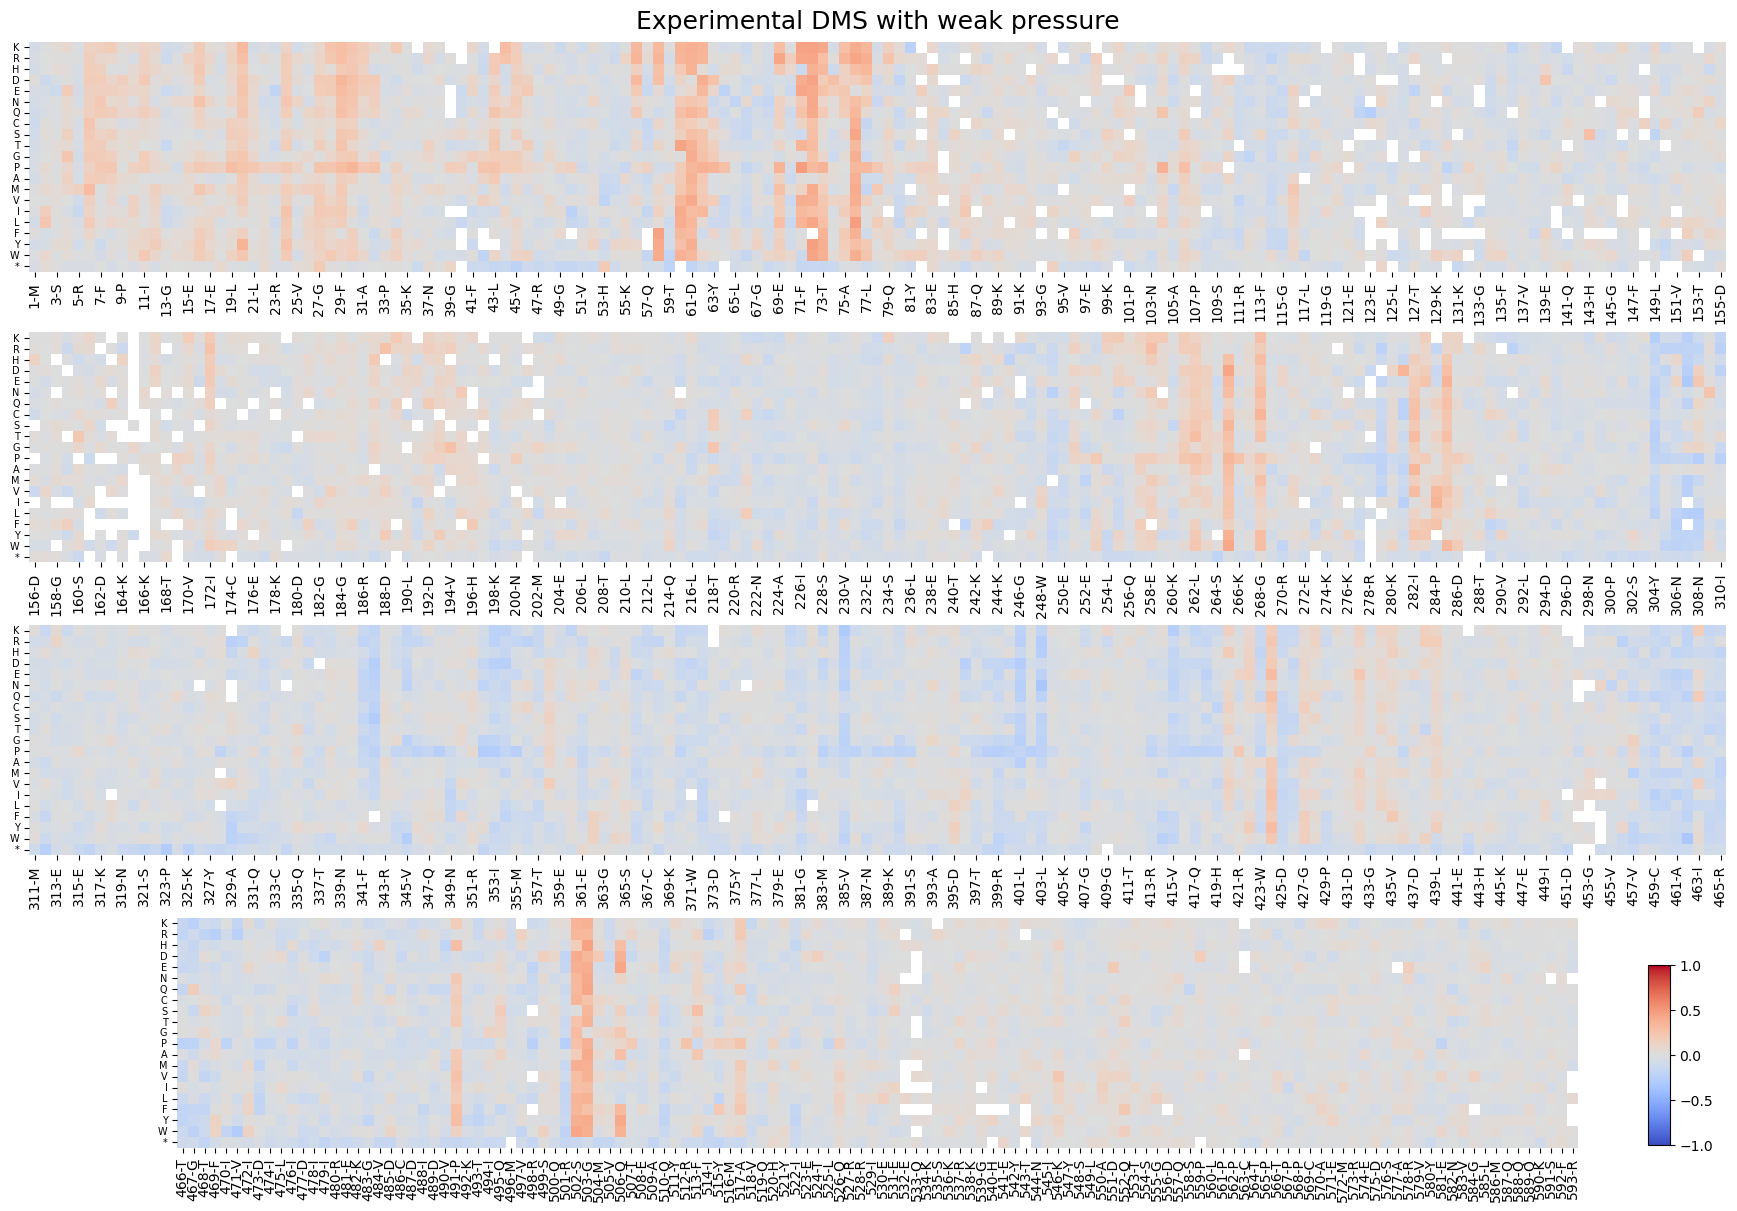

In [18]:
# load other experimental data
heatmap_sheet_SHP2_FL_cSrc = s['SHP2-FL_cSrc-KD_matrix'].copy()

heatmap_SHP2_FL_cSrc=DMS_reader(heatmap_sheet_SHP2_FL_cSrc)

#heatmap_SHP2_FL_cSrc
plot_heatmap(heatmap_SHP2_FL_cSrc, -1, 1, title='Experimental DMS with weak pressure')

In [19]:
# read the truncated construct data
# data directory
data_dir= '/Users/yunyao_1/Dropbox/SH2'
# excel file 
tr_data_dms = data_dir + '/media-6.xlsx'

s_tr = read_excel_sheets(tr_data_dms)
# print the names of the sheets
print("Sheets in the Excel file:")
for sheet_name in s_tr.keys():
    print(sheet_name)

Sheets in the Excel file:
SHP2-PTP_vSrc-FL_column
SHP2-PTP_cSrc-KD_column
SHP2-PTP_vSrc-FL_matrix
SHP2-PTP_cSrc-KD_matrix


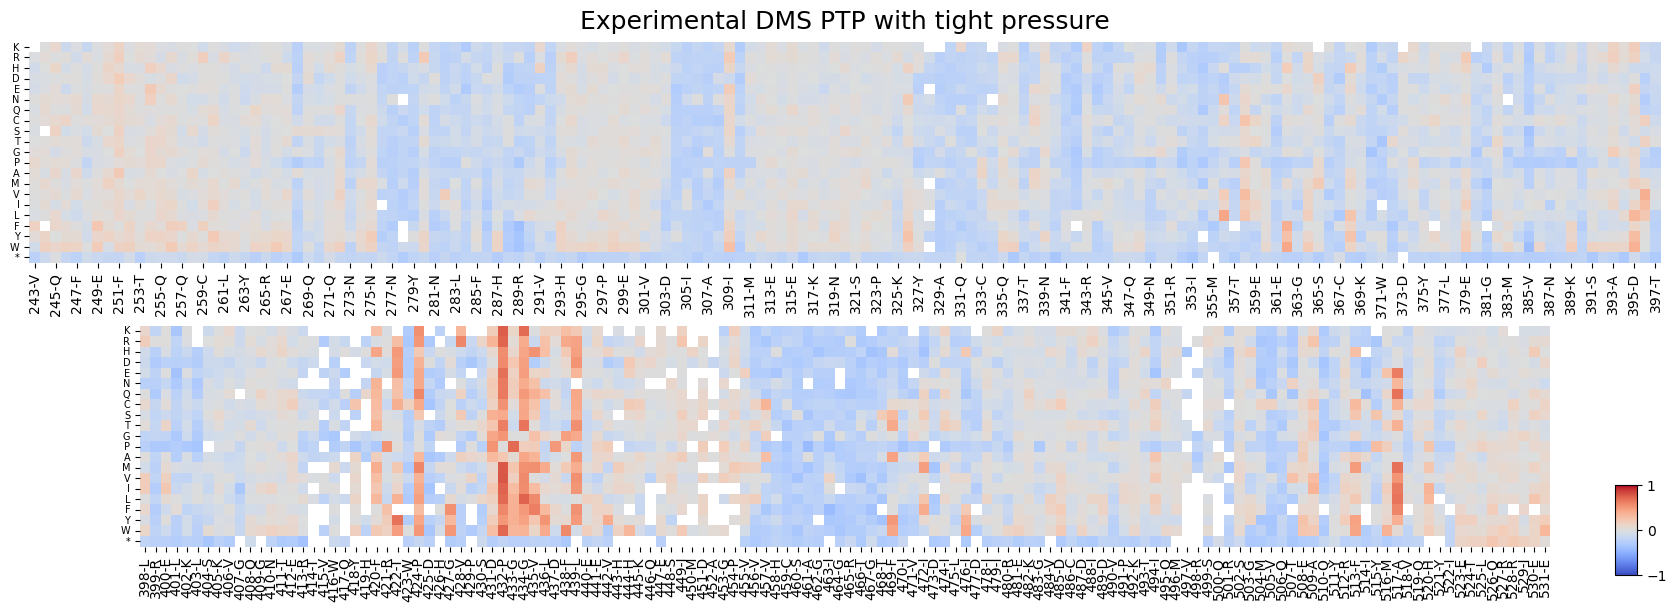

In [20]:
#  experimental data for truncated, tight pressure
heatmap_sheet_SHP2_PTP_vSrc = s_tr['SHP2-PTP_vSrc-FL_matrix'].copy()

heatmap_SHP2_PTP_vSrc=DMS_reader(heatmap_sheet_SHP2_PTP_vSrc)

#heatmap_SHP2_FL_cSrc
plot_heatmap(heatmap_SHP2_PTP_vSrc, -1, 1, title='Experimental DMS PTP with tight pressure')

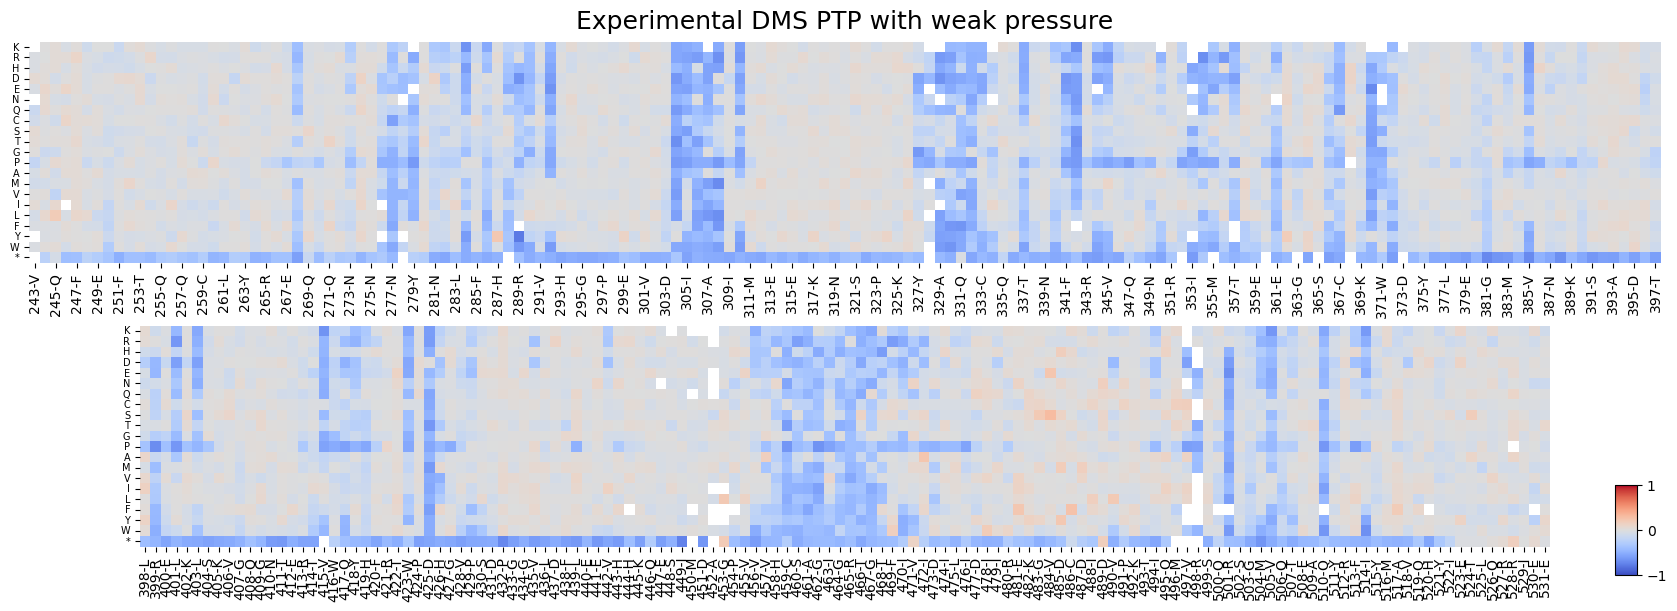

In [21]:
#  experimental data for truncated, weak pressure
heatmap_sheet_SHP2_PTP_cSrc = s_tr['SHP2-PTP_cSrc-KD_matrix'].copy()

heatmap_SHP2_PTP_cSrc=DMS_reader(heatmap_sheet_SHP2_PTP_cSrc)

#heatmap_SHP2_FL_cSrc
plot_heatmap(heatmap_SHP2_PTP_cSrc, -1, 1, title='Experimental DMS PTP with weak pressure')

In [22]:
# write a script to analyze single postion 

